In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from scipy.spatial.distance import cdist, pdist, squareform

plt.rcParams["figure.facecolor"] = "w"
plt.rcParams["figure.figsize"] = (6, 4.5)

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import pygeostat as gs

# import test data

In [4]:
data = gs.DataFile("test.dat", x="x", y="y", z="z")

In [5]:
data.data.head()

,x,y,z,var,wts
0,700.0,898.31,0.0,0.63722,0.00909
1,700.0,898.31,-20.0,0.54892,0.01803
2,700.0,898.31,-40.0,2.91808,0.02101
3,700.0,898.31,-60.0,2.95520,0.01803
4,700.0,898.31,-80.0,3.35011,0.01803


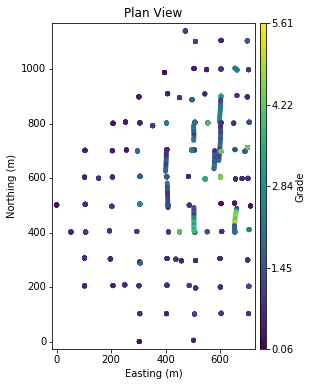

In [6]:
gs.locmap(
    data, nullv=-998, var="var", figsize=(6, 6), title="Plan View", cbar_label="Grade"
)
plt.savefig("plan-comps.png", bbox_inches="tight")

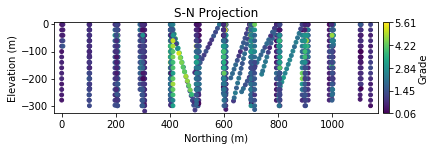

In [7]:
gs.locmap(
    data,
    nullv=-998,
    var="var",
    orient="yz",
    figsize=(6, 6),
    title="S-N Projection",
    cbar_label="Grade",
)
plt.savefig("sn-comps.png", bbox_inches="tight")

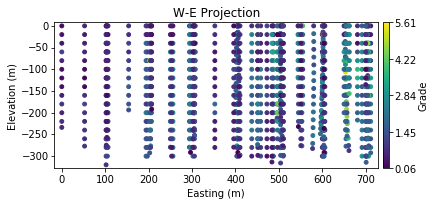

In [8]:
gs.locmap(
    data,
    nullv=-998,
    var="var",
    orient="xz",
    figsize=(6, 6),
    title="W-E Projection",
    cbar_label="Grade",
)
plt.savefig("we-comps.png", bbox_inches="tight")

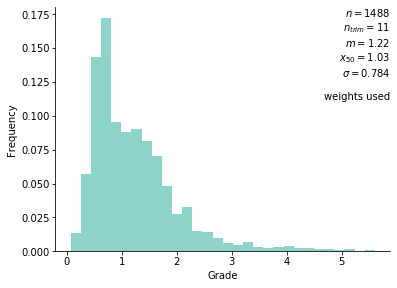

In [9]:
gs.histplt(data["var"], data["wts"], figsize=(6, 4.5), xlabel="Grade")
plt.savefig("base-hist.png", bbox_inches="tight")

In [10]:
locs = data.get_locations().values

In [11]:
griddef = data.infergriddef(75, 75, 50, 5.0)

In [12]:
grid_locs = griddef.gengridpoints()

Filter out estimation locations that are beyond 250m from data

In [13]:
tree = KDTree(locs)
max_distance = 150
idxs = np.array([i.shape[0] > 0 for i in tree.query_radius(grid_locs, max_distance)])

In [14]:
keep_idxs = np.arange(grid_locs.shape[0], dtype=int)[idxs]

In [15]:
grid_locs = grid_locs[idxs]

# Helper functions

In [16]:
def get_valid_inputs(locs, values):
    if hasattr(values, "values"):
        values = values.values
    idxs = np.isfinite(values)
    if idxs.all():
        idxs = values >= 0.0
    values = values[idxs]
    locs = locs[idxs]
    return values, locs

# NN

In [17]:
def get_nn_weights(distance):
    weights = np.ones_like(distance)
    return weights

In [18]:
def nn(data_locs, data_values, estimation_locs):
    data_values, data_locs = get_valid_inputs(data_locs, data_values)
    tree = KDTree(data_locs)
    dist, idxs = tree.query(grid_locs, k=1)
    weights = get_nn_weights(dist)
    est = np.sum(weights * data_values[idxs], axis=1)
    return est

In [19]:
nnest = nn(locs, data['var'], grid_locs)

# IDW

In [20]:
def get_idw_weights(distance, reg_const, power):
    weights = 1 / (reg_const + distance ** power)
    weights = weights / weights.sum(axis=1).reshape(-1, 1)
    return weights

In [21]:
def idw(
    data_locs, data_values, estimation_locs, power=2, reg_const=0.001, k_nearest=50,
):
    data_values, data_locs = get_valid_inputs(data_locs, data_values)
    tree = KDTree(data_locs)
    dist, idxs = tree.query(grid_locs, k=k_nearest)
    weights = get_idw_weights(dist, reg_const, power)
    est = np.sum(weights * data_values[idxs], axis=1)
    return est

In [22]:
idws = {}
for power in [2, 3, 4]:
    idws[power] = idw(locs, data["var"], grid_locs, power=power, k_nearest=35)

# kriging

## Covariance functions

In [23]:
class Covariance:
    def __init__(self, max_range, nugget, sill=1.0):
        self.max_range = max_range
        self.nugget = nugget
        self.sill = sill

    def apply_diag(self, cov_mat):
        """Set the diagonal to the sill of the model"""
        if cov_mat.ndim == 2 and cov_mat.shape[0] == cov_mat.shape[1]:
            # set the diagonal to the sill
            cov_mat[np.eye(cov_mat.shape[0], dtype=bool)] = self.sill
        return cov_mat

class SphericalCovariance(Covariance):
    def __call__(self, distance):
        """Calculate Spherical Covariance from `distance`"""
        distance = np.asarray(distance) / self.max_range
        covariance = np.zeros_like(distance)
        idxs = distance < 1.0
        covariance[idxs] = (self.sill - self.nugget) * \
            (1.0 - distance[idxs] * (1.5 - 0.5 * distance[idxs] ** 2))
        covariance = self.apply_diag(covariance)
        return covariance

class ExponentialCovariance(Covariance):
    def __call__(self, distance):
        """Calculate Exponential Covariance from `distance`"""
        distance = np.asarray(distance) / self.max_range
        covariance = (self.sill - self.nugget) * np.exp(-distance)
        covariance = self.apply_diag(covariance)
        return covariance

## SK

In [24]:
def get_simple_krige_weights(cov_func, data_locs, grid_data_dists):
    # Calculate the pairwise-distances
    square_data_data_dists = squareform(pdist(data_locs))
    # Convert distances to covariance
    Cij = cov_func(square_data_data_dists)
    Ciu = cov_func(grid_data_dists)
    # Solve for weights and return!
    weights = np.linalg.solve(Cij, Ciu)
    return weights

In [25]:
def simple_krige(
    data_locs, data_values, estimation_locs, vario_func, sk_mean=None, k_nearest=50
):
    data_values, data_locs = get_valid_inputs(data_locs, data_values)
    if sk_mean is None:
        sk_mean = data_values.mean()
    data_values -= sk_mean
    tree = KDTree(data_locs)
    dist, idxs = tree.query(estimation_locs, k=k_nearest)
    ests = np.full(estimation_locs.shape[0], np.nan)
    for i, (ix, dis) in enumerate(zip(idxs, dist)):
        weights = get_simple_krige_weights(vario_func, data_locs[ix], dis)
        ests[i] = np.dot(weights, data_values[ix])
    ests += sk_mean
    ests[ests < 0.0] = 0.0
    return ests

In [26]:
vario = SphericalCovariance(250, 0.001)

In [27]:
skest = simple_krige(locs, data["var"], grid_locs, vario, 1.22, 35)

## OK 

In [28]:
def get_ordinary_krige_weights(cov_func, data_locs, grid_data_dists):
    # Get the number of nearby locations, the `k` from the spatial search
    k_nearest = grid_data_dists.shape[0]
    # Setup the left-hand-side covariance matrix for OK
    Cij = np.ones((k_nearest + 1, k_nearest + 1))
    Cij[-1, -1] = 0.0
    # Calculate distances and convert to covariances
    square_data_data_dists = squareform(pdist(data_locs))
    Cij[:-1, :-1] = cov_func(square_data_data_dists)
    # Setup the right-hand-side covariance, calc distance and convert
    Ciu = np.ones(k_nearest + 1)
    Ciu[:-1] = cov_func(grid_data_dists)
    # Solve for weights, and return!
    weights = np.linalg.solve(Cij, Ciu)[:-1]
    return weights

In [29]:
def ordinary_krige(data_locs, data_values, estimation_locs, vario_func, k_nearest=50):
    data_values, data_locs = get_valid_inputs(data_locs, data_values)
    tree = KDTree(data_locs)
    dist, idxs = tree.query(estimation_locs, k=k_nearest)
    ests = np.full(estimation_locs.shape[0], np.nan)
    for i, (ix, dis) in enumerate(zip(idxs, dist)):
        weights = get_ordinary_krige_weights(vario_func, data_locs[ix], dis)
        ests[i] = np.dot(weights, data_values[ix])
    ests[ests < 0.0] = 0.0
    return ests

In [30]:
okest = ordinary_krige(locs, data["var"], grid_locs, vario, 35)

# RBF

In [31]:
def rbf(data_locs, data_values, estimation_locs, kernel):
    # Prep the data
    data_values, data_locs = get_valid_inputs(data_locs, data_values)
    # Compute the pairwise kernel matrix
    Kij = kernel(squareform(pdist(data_locs)))
    # Solve for the weights
    weights = np.linalg.solve(Kij, data_values)
    # Allocate array for estimates
    ests = np.full(grid_locs.shape[0], np.nan)
    for i, eloc in enumerate(estimation_locs):
        # Get the kernel-values from the estimation location to all data locations
        k = kernel(cdist(np.atleast_2d(eloc), data_locs))[0]
        ests[i] = np.dot(weights, k)
    ests[ests < 0.0] = 0.0
    return ests

In [32]:
class LinearKernel:
    def __call__(self, distance):
        return distance


class ThinPlateSpline:
    def __call__(self, distance):
        cov = np.zeros_like(distance)
        idxs = distance > 0.0
        cov[idxs] = np.log(distance[idxs]) * distance[idxs] ** 2
        return cov

In [33]:
rbfest = rbf(locs, data["var"], grid_locs, LinearKernel())

# Compare

In [34]:
id_names = [f"ID{p}" for p in idws.keys()]
id_models = [m for m in idws.values()]

In [35]:
models = id_models + [nnest, skest, okest, rbfest]
names = id_names + ["NN", "SK", "OK", "RBF"]

## Histogram

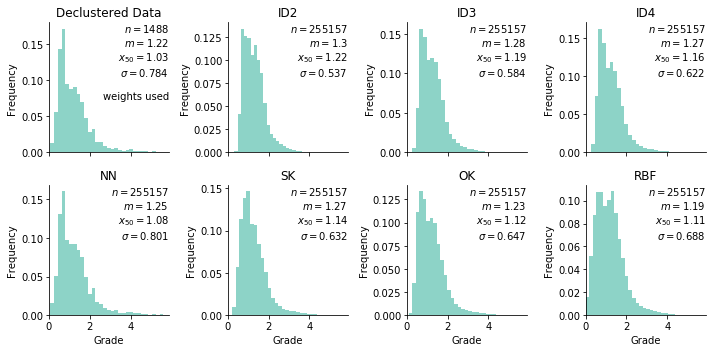

In [36]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5), sharex=True)
idxs = data["var"].notna() & (data["var"] >= 0.0)
gs.histplt(
    data["var"][idxs], data["wts"][idxs], ax=axes[0, 0], title="Declustered Data",
)
for ax, mod, t in zip(axes.flatten()[1:], models, names):
    xlabel = "Grade" if "ID" not in t else ""
    gs.histplt(mod, ax=ax, title=t, xlim=(0, None), xlabel=xlabel)
fig.tight_layout()
fig.savefig("histograms.png", bbox_inches="tight")

## Spatial

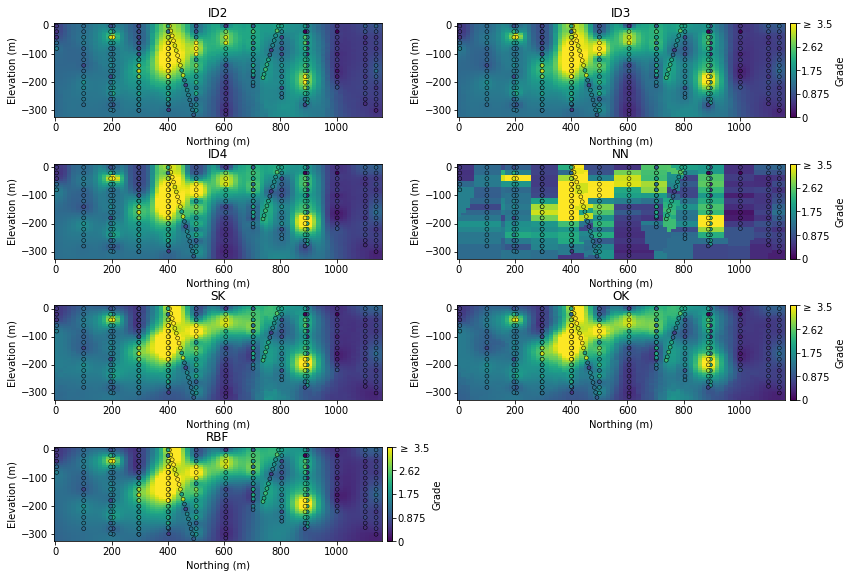

In [37]:
fig, axes = plt.subplots(4, 2, figsize=(12, 8))
orient = "yz"
sliceno = 50
vlim = (0, 3.5)

for iax, (ax, mod, t) in enumerate(zip(axes.flatten(), models, names)):
    # fill out the model to griddef shape
    tmod = np.full(griddef.count(), np.nan)
    tmod[keep_idxs] = mod
    gs.pixelplt(
        tmod,
        griddef,
        ax=ax,
        sliceno=sliceno,
        title=t,
        orient=orient,
        vlim=vlim,
        cbar=True,
    )
    irow, icol = int(iax / 3), iax % 3
    if iax in [0, 2, 4]: 
        ax.cax.remove()
    gs.locmap(
        data,
        var="var",
        griddef=griddef,
        sliceno=sliceno,
        title=t,
        nullv=-998,
        orient=orient,
        ax=ax,
        slicetol=4,
        vlim=vlim,
        edgecolors="k",
        lw=0.5,
        cbar=iax not in [0, 2, 4],
        cbar_label="Grade",
    )
axes[-1, -1].set_axis_off()
fig.tight_layout()
fig.savefig("ns-slices.png", bbox_inches="tight")

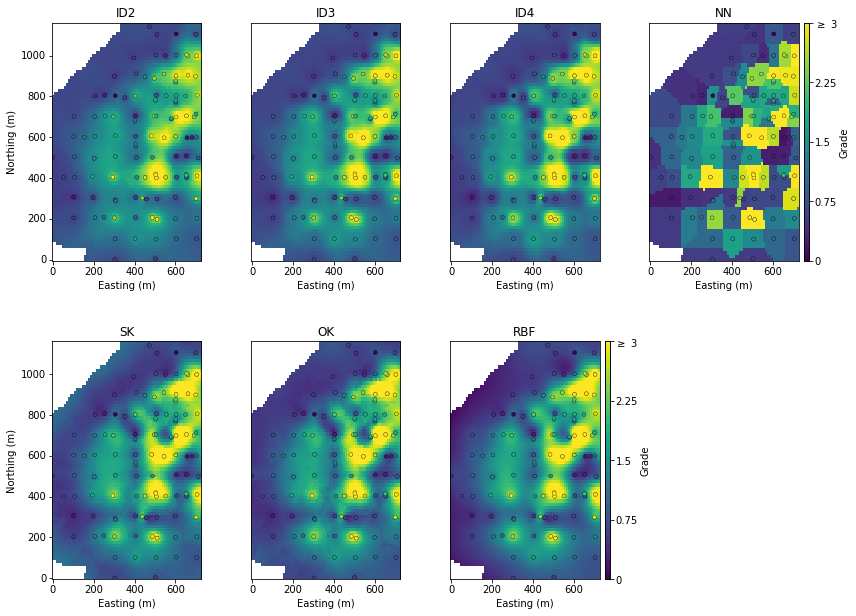

In [38]:
fig, axes = plt.subplots(2, 4, figsize=(12, 9))
orient = "xy"
sliceno = 41
vlim = (0, 3)

for iax, (ax, mod, t) in enumerate(zip(axes.flatten(), models, names)):
    # fill out the model to griddef shape
    tmod = np.full(griddef.count(), np.nan)
    tmod[keep_idxs] = mod
    gs.pixelplt(
        tmod,
        griddef,
        ax=ax,
        sliceno=sliceno,
        title=t,
        orient=orient,
        vlim=vlim,
        cbar=True,
    )
    irow, icol = int(iax / 4), iax % 4
    if iax not in [3, 6]:
        ax.cax.remove()
    gs.locmap(
        data,
        var="var",
        griddef=griddef,
        sliceno=sliceno,
        title=t,
        nullv=-998,
        orient=orient,
        ax=ax,
        slicetol=3,
        vlim=vlim,
        edgecolors="k",
        lw=0.25,
        cbar=iax in [3, 6],
        cbar_label='Grade'
    )
    if icol > 0:
        ax.set_ylabel('')
        ax.yaxis.set_major_locator(plt.NullLocator())
for ax in axes.flatten()[7:]:
    ax.set_axis_off()
fig.tight_layout(w_pad=-0.1)
fig.savefig("plan-views.png", bbox_inches="tight")